<a href="https://colab.research.google.com/github/minji0620/sk_broadband/blob/main/modeling/%EA%B8%B0%EC%97%85%EC%97%B0%EA%B3%84_ML(%ED%8A%9C%EB%8B%9D_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.23.5 pandas==1.5.3  # 버전 호환성 보장
!pip install optuna scikit-learn matplotlib

  Using cached optuna-4.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
Using cached optuna-4.2.1-py3-none-any.whl (383 kB)
Using cached alembic-1.15.2-py3-none-any.whl (231 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)


In [ ]:
# 필요한 라이브러리 설치
!pip install optuna

# 데이터 로드 및 전처리

In [ ]:
# 데이터 로드
import pandas as pd

# 파일 업로드
from google.colab import files
uploaded = files.upload()

# 파일 읽기 (인코딩 문제 해결)
data = pd.read_csv("iptv_data(50000).csv", encoding='latin1')


Saving iptv_data(50000).csv to iptv_data(50000).csv


In [ ]:
# 데이터 전처리 전체 코드 (경고 없음)
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# 데이터 로드 및 결측값 처리
data = pd.read_csv("iptv_data(50000).csv", encoding='latin1')
data_cleaned = data.dropna().copy()

# 타겟 변수 분리
y = data_cleaned['iptv_yn']
X = data_cleaned.drop(columns=['iptv_yn'])

# 범주형/수치형 분리
categorical_cols = [
    'ContractPVCName',
    'ResidenceBuildingTypeCode',
    'Gender',
    'ReAgreementYesNo',
    'TransferYesNo',
    'WifiSubscriptionYesNo',
    'SalesSmallYesNo',
    'InternetProductName',
    'MaxGeneralConsultationCount',
    'MaxQualityConsultationCount',
    'MaxTermConsultationCount',
    'MaxSaleConsultationCount',
    'MaxFeeConsultationCount',
    'MaxEtcConsultationCount',
    'AgeGroup'
]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

X_cat = X[categorical_cols].copy()  # 복사본 생성
X_num = X[numerical_cols].copy()

# 범주형 변수 인코딩
for col in categorical_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col].astype(str))

# 수치형 변수 스케일링
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=numerical_cols)

# 데이터 병합
X_processed = pd.concat([X_cat, X_num_scaled], axis=1)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# 클래스 가중치 적용 및 모델 학습 (Random Forest)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 교차 검증 (StratifiedKFold)
skf = StratifiedKFold(n_splits=5)
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_model.fit(X_fold_train, y_fold_train)
    score = rf_model.score(X_fold_val, y_fold_val)
    print(f"Fold {fold_idx + 1} Validation Score: {score:.3f}")


Fold 1 Validation Score: 0.887
Fold 2 Validation Score: 0.890
Fold 3 Validation Score: 0.886
Fold 4 Validation Score: 0.883
Fold 5 Validation Score: 0.892


# 랜덤포레스트와 SelectFromModel 사용

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# 랜덤 포레스트 초기화 및 피처 선택
rf = RandomForestClassifier(random_state=42)
sfm = SelectFromModel(rf)
sfm.fit(X_train, y_train)

# 선택된 피처로 데이터 변환
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)


# Optuna를 사용한 하이퍼파라미터 튜닝

In [ ]:
import optuna
from sklearn.metrics import roc_auc_score

# Optuna 최적화 함수 정의
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf.fit(X_train_selected, y_train)
    y_pred_proba = rf.predict_proba(X_test_selected)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

# Optuna 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

# 최적 하이퍼파라미터로 모델 학습
best_params = study.best_params
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train_selected, y_train)

print("\n최적 하이퍼파라미터:")
print(best_params)

[I 2025-04-07 02:25:33,449] A new study created in memory with name: no-name-e945413b-1235-4059-833d-33c2cbc15cb2
[I 2025-04-07 02:25:36,223] Trial 0 finished with value: 0.8617217832685354 and parameters: {'n_estimators': 157, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8617217832685354.
[I 2025-04-07 02:25:41,385] Trial 1 finished with value: 0.8704244568378083 and parameters: {'n_estimators': 159, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8704244568378083.
[I 2025-04-07 02:25:43,470] Trial 2 finished with value: 0.868575506648865 and parameters: {'n_estimators': 88, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8704244568378083.
[I 2025-04-07 02:25:48,756] Trial 3 finished with value: 0.8702338202306056 and parameters: {'n_estimators': 158, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 1 with value: 0


최적 하이퍼파라미터:
{'n_estimators': 134, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 10}


# 성능 평가 및 시각화


학습 vs 테스트 성능 비교:
       Accuracy  Precision  Recall     F1  AUC-ROC
Train     0.978      0.981   0.995  0.988    0.989
Test      0.887      0.906   0.973  0.938    0.885


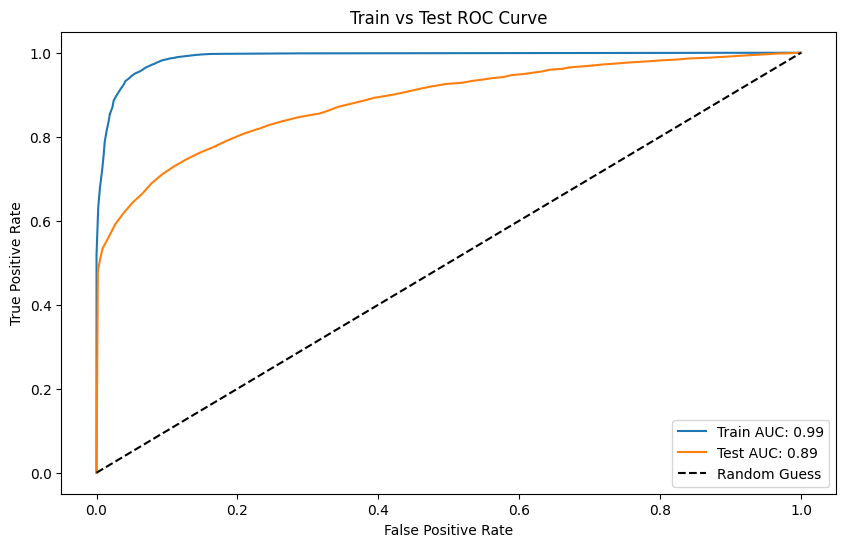

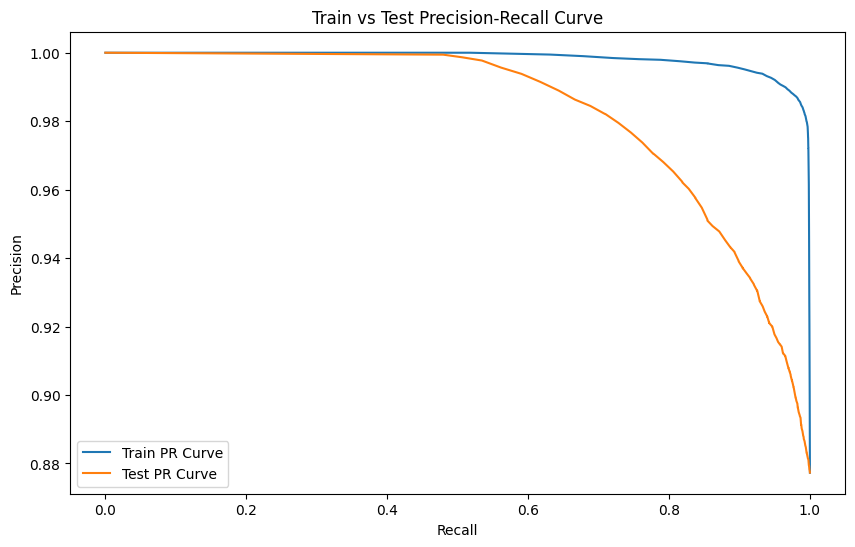

학습 데이터 Classification Report:
              precision    recall  f1-score   support

           N       0.96      0.86      0.91      4113
           Y       0.98      0.99      0.99     29409

    accuracy                           0.98     33522
   macro avg       0.97      0.93      0.95     33522
weighted avg       0.98      0.98      0.98     33522


테스트 데이터 Classification Report:
              precision    recall  f1-score   support

           N       0.58      0.28      0.37      1028
           Y       0.91      0.97      0.94      7353

    accuracy                           0.89      8381
   macro avg       0.75      0.62      0.66      8381
weighted avg       0.87      0.89      0.87      8381



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report

# 예측값 생성
y_train_pred = rf_model.predict(X_train)
y_train_pred_proba = rf_model.predict_proba(X_train)[:, 1]  # 클래스 1의 확률

y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # 클래스 1의 확률

# 성능 지표 계산 함수 (문자열 레이블 대응)
def calculate_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, pos_label='Y'),  # pos_label='Y' 추가
        'Recall': recall_score(y_true, y_pred, pos_label='Y'),        # pos_label='Y' 추가
        'F1': f1_score(y_true, y_pred, pos_label='Y'),                # pos_label='Y' 추가
        'AUC-ROC': roc_auc_score((y_true == 'Y').astype(int), y_proba) # 레이블 이진화
    }

# 학습/테스트 성능 비교
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_proba)
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)

# 결과를 DataFrame으로 변환
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])
print("\n학습 vs 테스트 성능 비교:")
print(metrics_df.round(3))

# ROC-AUC 커브 비교
fpr_train, tpr_train, _ = roc_curve((y_train == 'Y').astype(int), y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve((y_test == 'Y').astype(int), y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC: {roc_auc_score((y_train == "Y").astype(int), y_train_pred_proba):.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC: {roc_auc_score((y_test == "Y").astype(int), y_test_pred_proba):.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train vs Test ROC Curve')
plt.legend()
plt.show()

# PR 커브 비교
precision_train, recall_train, _ = precision_recall_curve((y_train == 'Y').astype(int), y_train_pred_proba)
precision_test, recall_test, _ = precision_recall_curve((y_test == 'Y').astype(int), y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall_train, precision_train, label='Train PR Curve')
plt.plot(recall_test, precision_test, label='Test PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Train vs Test Precision-Recall Curve')
plt.legend()
plt.show()

# Classification Report (타겟 이름 명시적 지정)
print("학습 데이터 Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=['N', 'Y']))

print("\n테스트 데이터 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['N', 'Y']))
